In [1]:
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# training images

In [2]:
data_folder = 'images/train'  
image_size = (48,48)  
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
image_train=[]
train_label = [] 
for subfolder in tqdm(subfolders):
    label = os.path.basename(subfolder)  
    for file in os.listdir(subfolder):
        file_path = os.path.join(subfolder, file)
        image = cv2.imread(file_path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_train.append(image)
        train_label.append(label)
image_train=np.array(image_train)
train_label=np.array(train_label)

  0%|          | 0/7 [00:00<?, ?it/s]

# validation images

In [3]:
data_folder = 'images/validation'  
image_size = (48,48)  
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
image_val=[]
val_label = [] 
for subfolder in tqdm(subfolders):
    label = os.path.basename(subfolder)  
    for file in os.listdir(subfolder):
        file_path = os.path.join(subfolder, file)
        image = cv2.imread(file_path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_val.append(image)
        val_label.append(label)
image_val=np.array(image_val)
val_label=np.array(val_label)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images/validation'

In [4]:
image_train.shape

(25783, 48, 48)

In [6]:
image_val.shape

(7066, 48, 48)

In [7]:
image_train[1]

array([[152, 149, 147, ..., 129, 139, 121],
       [149, 152, 150, ..., 121, 146, 135],
       [152, 152, 157, ..., 112, 121, 145],
       ...,
       [187, 189, 120, ..., 184, 185, 188],
       [188, 189, 193, ..., 185, 181, 189],
       [186, 185, 183, ..., 193, 181, 183]], dtype=uint8)

In [8]:
image_train[3].shape

(48, 48)

In [9]:
np.unique(train_label,return_counts=True)

(array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype='<U8'),
 array([3993,  436, 4103, 7164, 4982, 4938,  167], dtype=int64))

In [10]:
np.unique(val_label,return_counts=True)

NameError: name 'val_label' is not defined

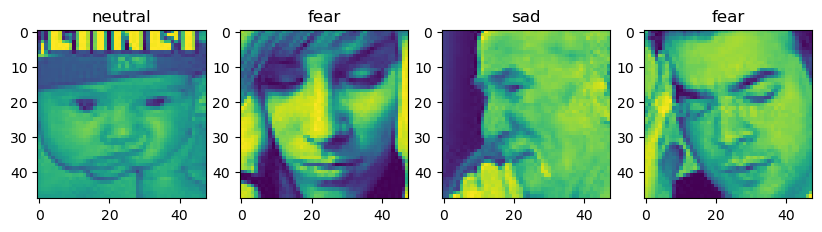

In [13]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    plt.subplot(1,4,i)
    index=np.random.randint(image_train.shape[0],size=1)[0]
    plt.imshow(image_train[index])
    plt.title(train_label[index])

In [11]:
image_train = image_train.astype('float32')
image_train /= 255.0
image_val = image_val.astype('float32')
image_val /= 255.0

In [10]:
image_train[6]

array([[ 35,  32,  26, ...,  52,  59,  63],
       [ 30,  29,  27, ...,  51,  58,  63],
       [ 22,  25,  29, ...,  49,  58,  63],
       ...,
       [209, 184, 143, ..., 114, 138, 153],
       [145, 129, 103, ..., 103, 126, 141],
       [106,  95,  78, ...,  96, 119, 134]], dtype=uint8)

In [13]:
label_df_train=pd.DataFrame(train_label)
label_df_val=pd.DataFrame(val_label)

In [14]:
label_df_train=pd.get_dummies(label_df_train,dtype="int")
label_df_val=pd.get_dummies(label_df_val,dtype="int")

In [15]:
label_df_val.sample(5)

,0_angry,0_disgust,0_fear,0_happy,0_neutral,0_sad,0_surprise
3855,0,0,0,1,0,0,0
1665,0,0,1,0,0,0,0
6874,0,0,0,0,0,0,1
1349,0,0,1,0,0,0,0
5591,0,0,0,0,0,1,0


In [16]:
image_train.shape,label_df_train.shape

((28821, 84, 84), (28821, 7))

In [19]:
image_train.shape,label_df_train.shape

((25938, 84, 84), (25938, 7))

# model creation

In [14]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(84,84, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 82, 82, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 41, 41, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

In [24]:
# Training the model  the model
history=model.fit(image_train,label_df_train, epochs=8, batch_size=64, validation_data=(image_val,label_df_val))

Epoch 1/8
406/406 [==============================] - 286s 692ms/step - loss: 1.7510 - accuracy: 0.2905 - val_loss: 1.5775 - val_accuracy: 0.3903
Epoch 2/8
406/406 [==============================] - 304s 750ms/step - loss: 1.5557 - accuracy: 0.3935 - val_loss: 1.4242 - val_accuracy: 0.4566
Epoch 3/8
406/406 [==============================] - 244s 601ms/step - loss: 1.4372 - accuracy: 0.4422 - val_loss: 1.3654 - val_accuracy: 0.4863
Epoch 4/8
406/406 [==============================] - 293s 721ms/step - loss: 1.3603 - accuracy: 0.4797 - val_loss: 1.2982 - val_accuracy: 0.5106
Epoch 5/8
406/406 [==============================] - 314s 774ms/step - loss: 1.3035 - accuracy: 0.5001 - val_loss: 1.2666 - val_accuracy: 0.5175
Epoch 6/8
406/406 [==============================] - 317s 780ms/step - loss: 1.2515 - accuracy: 0.5246 - val_loss: 1.2490 - val_accuracy: 0.5253
Epoch 7/8
406/406 [==============================] - 310s 764ms/step - loss: 1.1952 - accuracy: 0.5425 - val_loss: 1.2476 - val_ac

In [25]:

test_loss, test_acc = model.evaluate(image_test, label_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Make predictions using the trained model
predictions = model.predict(image_test)

91/91 [==============================] - 9s 97ms/step - loss: 1.2228 - accuracy: 0.5331
Test accuracy: 53.31%
91/91 [==============================] - 11s 110ms/step


In [38]:
predsoft=np.argmax(predictions,axis=1)

In [35]:
pred_dict={0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Normal",5:"Sad",6:"suprise"}

In [5]:
train_acc=history.history["accuracy"]
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]
val_acc=history.history["val_accuracy"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')Z
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

SyntaxError: invalid syntax (1631680538.py, line 7)

In [36]:
model.save('facial_expression_model.h5')

In [42]:
from sklearn.metrics import accuracy_score

In [52]:
test_label=np.argmax(label_test,axis=1)
test_label

array([3, 5, 5, ..., 5, 2, 0], dtype=int64)

In [54]:
accuracy_score(test_label,predsoft)

0.533125216788068